In [1]:
from __future__ import print_function

import numpy as np
import seaborn as sbn
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import scipy.io

from itertools import izip

plt.style.use('classic')
mpl.rcParams['axes.xmargin'] = 0.0
mpl.rcParams['axes.ymargin'] = 0.0

%matplotlib notebook

In [2]:
data = scipy.io.loadmat ('ex8data1.mat')
X = data['X']
X_val = data['Xval']
y_val = (data['yval'].T[0]).astype (int)

<IPython.core.display.Javascript object>


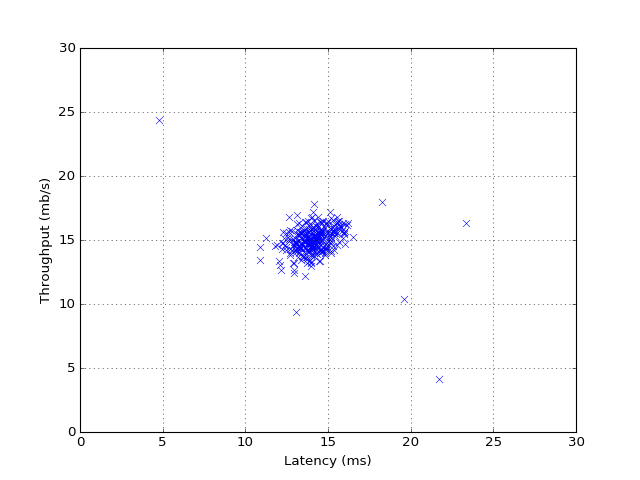

In [3]:
fig = plt.figure ()
ax = fig.add_subplot (111)
ax.scatter (X[:, 0], X[:, 1], marker='x', c='b', lw=0.5, s=40)
ax.set_xlim (0, 30)
ax.set_ylim (0, 30)
ax.set_xlabel ('Latency (ms)')
ax.set_ylabel ('Throughput (mb/s)')
ax.grid ()

In [4]:
def estimateGaussian (X):
    mu = np.mean (X, axis=0)
    sigma2 = np.mean ((X - mu)**2, axis=0)
    return (mu, sigma2)

def multivariateGaussian (X, mu, Sigma2):
    k = len (mu)
    
    # Handle Sigma2 if each variable has been treated individually
    if np.any (Sigma2.shape == 1) or len (Sigma2.shape) == 1:
        Sigma2 = np.diag (Sigma2)
        
    X = X - mu
    p = (2. * np.pi)**(-k / 2.) * np.linalg.det (Sigma2)**(-0.5) * \
        np.exp (-0.5 * np.sum (
                    np.dot (X, np.linalg.pinv (Sigma2)) * X, axis=1))
        
    return (p)

In [5]:
mu, sigma2 = estimateGaussian (X)
p = multivariateGaussian (X, mu, sigma2)

In [6]:
def visualizeFit (X, mu, sigma2):
    x1s = np.linspace (0, 35, 100)
    x2s = np.linspace (0, 35, 100)
    x1s_grid, x2s_grid = np.meshgrid (x1s, x2s)
    z = multivariateGaussian (np.hstack ((x1s_grid.reshape (-1, 1),
                                          x2s_grid.reshape (-1, 1))),
                              mu, sigma2).reshape (x1s_grid.shape)
    levels = (10.**np.arange (-20, 0, step=3)).tolist ()

    fig = plt.figure ()
    ax = fig.add_subplot (111)
    ax.scatter (X[:, 0], X[:, 1], marker='x', c='b', lw=0.5, s=40)
    ax.contour (x1s_grid, x2s_grid, z, levels=levels)
    ax.set_xlim (0, 30)
    ax.set_ylim (0, 30)
    ax.set_xlabel ('Latency (ms)')
    ax.set_ylabel ('Throughput (mb/s)')
    ax.grid ()
    
    return (fig, ax)

<IPython.core.display.Javascript object>


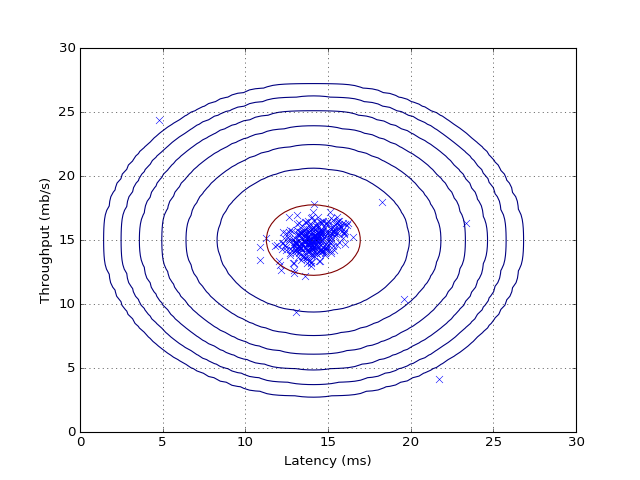

(<matplotlib.figure.Figure at 0x7fa19b7a3e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa173bf7b90>)

In [7]:
visualizeFit (X, mu, sigma2)

In [8]:
def selectThreshold (y_val, p_val):
    best_eps = 0.
    best_F1 = 0. 
    F1 = 0
    
    for eps in np.linspace (p_val.min (), p_val.max (), num=1001):
        pred = (p_val < eps)
        prec = pred[y_val == 1].sum () / float (pred.sum ())
        rec = y_val[pred].sum () / float (y_val.sum ())
        F1 = 2. * prec * rec / (prec + rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_eps = eps
    
    return (best_eps, best_F1)

In [9]:
mu, sigma2 = estimateGaussian (X)
p_val = multivariateGaussian (X_val, mu, sigma2)
eps, F1 = selectThreshold (y_val, p_val)

print ('Best epsilon found using cross-validation: {0:e}'.format (eps))
print ('Best F1 on Cross Validation Set: {0:f}'.format (F1))
print ('# Outliers found: {0:d}'.format((p < eps).sum ()))
print ('    (you should see a value epsilon of about 8.99e-05)')

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000
# Outliers found: 6
    (you should see a value epsilon of about 8.99e-05)


<IPython.core.display.Javascript object>


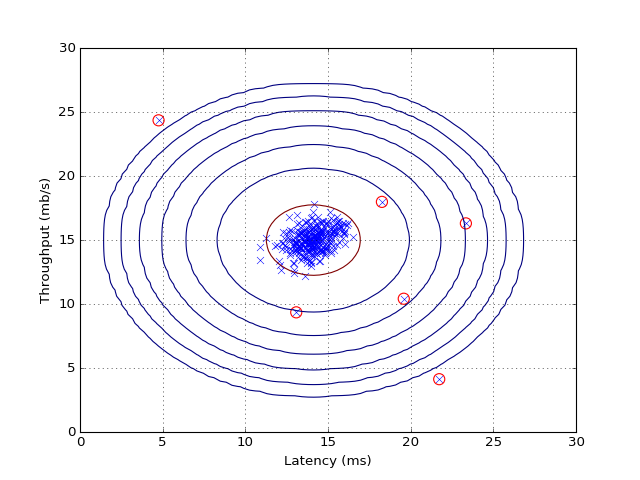

In [10]:
outliers = (p < eps)
fig, ax = visualizeFit (X, mu, sigma2)
ax.scatter (X[outliers, 0], X[outliers, 1], 
            marker='o', c='None', s=100, edgecolor='r')

In [11]:
data = scipy.io.loadmat ('ex8data2.mat')
X = data['X']
X_val = data['Xval']
y_val = data['yval'].T[0].astype (int)

In [12]:
mu, sigma2 = estimateGaussian (X)
p = multivariateGaussian (X, mu, sigma2)
p_val = multivariateGaussian (X_val, mu, sigma2)
eps, F1 = selectThreshold (y_val, p_val)

print ('Best epsilon found using cross-validation: {0:e}'.format (eps))
print ('Best F1 on Cross Validation Set: {0:f}'.format (F1))
print ('# Outliers found: {0:d}'.format((p < eps).sum ()))
print ('    (you should see a value epsilon of about 1.38e-18)')

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set: 0.615385
# Outliers found: 117
    (you should see a value epsilon of about 1.38e-18)


## Collaborative Filtering

In [73]:
data = scipy.io.loadmat ('ex8_movies.mat')
Y = data['Y']
R = data['R']
data = scipy.io.loadmat ('ex8_movieParams.mat')
X = data['X']
Theta = data['Theta']

print ('Average rating for movie 1 (Toy Story): {0:f} / 5'.format (
    Y[0, R[0].astype (bool)].mean ()))

Average rating for movie 1 (Toy Story): 3.878319 / 5


<IPython.core.display.Javascript object>


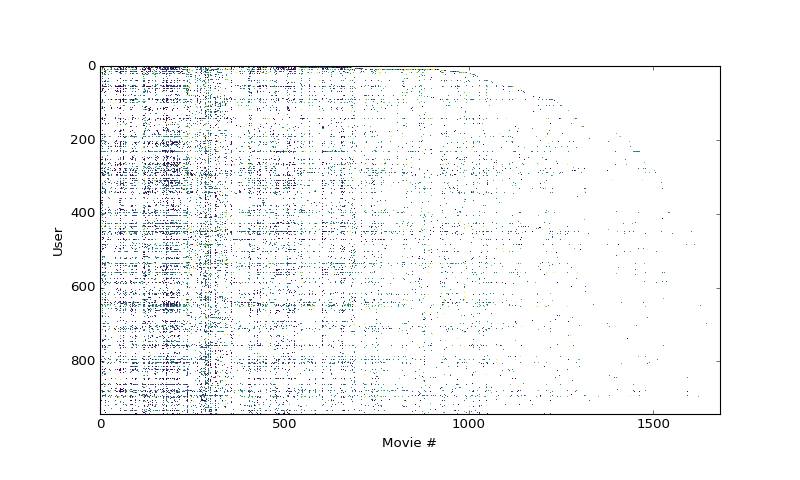

In [14]:
cmap = plt.cm.viridis_r
Y_masked = np.ma.masked_where (np.logical_not (R), Y)

fig = plt.figure (figsize=(10, 6))
ax = fig.add_subplot (111)
ax.imshow (Y_masked.T, cmap=cmap, interpolation='nearest',
           vmin=1, vmax=5)
ax.set_xlabel ('Movie #')
ax.set_ylabel ('User')

In [15]:
def cofiCostFunc (params, Y, R, 
                  num_users, num_movies, num_features, lambda_reg):
    X = params[:(num_movies*num_features)].reshape (
        num_movies, num_features)
    Theta = params[(num_movies*num_features):].reshape (
        num_users, num_features)
    
    J = 1./2. * np.sum ((X.dot (Theta.T) - Y)**2 * R) + \
        lambda_reg/2. * (np.sum (Theta**2) + np.sum (X**2))
        
    return (J)

def cofiCostFuncGradient (params, Y, R, 
                          num_users, num_movies, num_features, 
                          lambda_reg):
    X = params[:(num_movies*num_features)].reshape (
        num_movies, num_features)
    Theta = params[(num_movies*num_features):].reshape (
        num_users, num_features)
    
    X_grad = ((X.dot (Theta.T) - Y) * R).dot (Theta) + \
        lambda_reg * X;
    Theta_grad = ((X.dot (Theta.T) - Y) * R).T.dot (X) + \
        lambda_reg * Theta;
        
    return (np.r_[X_grad.flatten (), Theta_grad.flatten ()])

def numericalGradient (func, params):
    num_grad = np.zeros (params.shape)
    perturb = np.zeros (params.shape)
    eps = 1e-4
    
    for p in range (params.size):
        perturb[p] = eps
        loss1 = func (params - perturb)
        loss2 = func (params + perturb)
        num_grad[p] = (loss2 - loss1) / (2.*eps)
        perturb[p] = 0.
        
    return (num_grad)

In [16]:
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

J = cofiCostFunc (np.r_[X.flatten (), Theta.flatten ()], Y, R,
                  num_users, num_movies, num_features, 0.)
print ('Cost at loaded parameters: {0:f}'.format (J))
print ('(this value should be about 22.22)')

Cost at loaded parameters: 22.224604
(this value should be about 22.22)


In [17]:
def checkCostFunction (lambda_reg, num_users, num_movies, num_features):
    X_t = np.random.uniform (size=(num_movies, num_features))
    Theta_t = np.random.uniform (size=(num_users, num_features))
    Y = X_t.dot (Theta_t.T)
    Y[np.random.uniform(size=Y.shape) > 0.5] = 0
    R = np.zeros (Y.shape, dtype=int)
    R[Y > 0] = 1
    
    X = np.random.normal (size=X_t.shape)
    Theta = np.random.normal (size=Theta_t.shape)
    
    func = lambda params, Y=Y, R=R, num_users=num_users, \
        num_movies=num_movies, num_features=num_features, \
        lambda_reg=lambda_reg: cofiCostFunc (
            params, Y, R, num_users, num_movies, num_features,
            lambda_reg)
    
    grad = cofiCostFuncGradient (np.r_[X.flatten (), Theta.flatten ()],
                                 Y, R, num_users, num_movies, 
                                 num_features, lambda_reg)
    
    num_grad = numericalGradient (
        func, np.r_[X.flatten (), Theta.flatten ()])
    
    diff = np.linalg.norm (num_grad - grad) / \
        np.linalg.norm (num_grad + grad) 
        
    print (np.hstack ((num_grad.reshape ((-1, 1)), grad.reshape ((-1, 1)))))
    print ('')
    print ('The above two columns you get should be very similar.')
    print ('(Left-Numerical Gradient, Right-Analytical Gradient)')
    print ('')
    print ('If your backpropagation implementation is correct, then ')
    print ('the relative difference will be small (less than 1e-9). ')
    print ('Relative Difference: {0:e}'.format (diff))

In [18]:
checkCostFunction (0., 4, 5, 3)

[[ 2.25074673  2.25074673]
 [-3.06295155 -3.06295155]
 [ 5.75634056  5.75634056]
 [ 0.85519463  0.85519463]
 [ 0.17985168  0.17985168]
 [-0.50418705 -0.50418705]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.09871339 -0.09871339]
 [ 0.26018384  0.26018384]
 [ 0.21607577  0.21607577]
 [ 1.29406881  1.29406881]
 [ 3.43506351  3.43506351]
 [-5.97853193 -5.97853193]
 [ 1.22491559  1.22491559]
 [-3.17978907 -3.17978907]
 [-0.26009595 -0.26009595]
 [-0.05219402 -0.05219402]
 [ 1.17956609  1.17956609]
 [ 0.23063788  0.23063788]
 [-1.36777413 -1.36777413]
 [ 5.96507668  5.96507668]
 [ 0.85331146  0.85331146]
 [-0.22368026 -0.22368026]
 [ 2.94937347  2.94937347]
 [ 0.55538112  0.55538112]]

The above two columns you get should be very similar.
(Left-Numerical Gradient, Right-Analytical Gradient)

If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1e-9). 
Relative Difference: 4.974468e-13


In [19]:
J = cofiCostFunc (np.r_[X.flatten (), Theta.flatten ()], Y, R,
                  num_users, num_movies, num_features, 1.5)
print ('Cost at loaded parameters (lambda = 1.5): {0:f}'.format (J))
print ('(this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.344056
(this value should be about 31.34)


In [20]:
checkCostFunction (1.5, 4, 5, 3)

[[ -0.23287811  -0.23287811]
 [  0.20292335   0.20292335]
 [ -0.18502501  -0.18502501]
 [ -2.49562989  -2.49562989]
 [ -8.24999044  -8.24999044]
 [ -0.59277771  -0.59277771]
 [ -0.74162475  -0.74162475]
 [ -1.43407884  -1.43407884]
 [ -0.80138009  -0.80138009]
 [ -5.08330883  -5.08330883]
 [  0.9740336    0.9740336 ]
 [  2.68009265   2.68009265]
 [ -0.44546931  -0.44546931]
 [  0.53652131   0.53652131]
 [  0.65464164   0.65464164]
 [  6.26397794   6.26397794]
 [ 11.48408192  11.48408192]
 [  1.12779236   1.12779236]
 [  1.26953403   1.26953403]
 [  0.28332959   0.28332959]
 [  1.26657941   1.26657941]
 [ -0.93400799  -0.93400799]
 [ -0.37648571  -0.37648571]
 [  0.35524346   0.35524346]
 [  0.10614343   0.10614343]
 [  1.77310646   1.77310646]
 [ -0.63096304  -0.63096304]]

The above two columns you get should be very similar.
(Left-Numerical Gradient, Right-Analytical Gradient)

If your backpropagation implementation is correct, then 
the relative difference will be small (less than 1

In [21]:
def loadMovieList ():
    movie_list = []
    
    f = open ('movie_ids.txt')
    for l in f:
        num, movie = l.replace ('\n', '').split (' ', 1)
        movie_list.append (movie)
        
    return (np.array (movie_list, dtype=str))

In [22]:
movies = loadMovieList ()

In [23]:
my_ratings = np.zeros (len (movies))
my_ratings[0] = 4.
my_ratings[97] = 2.
my_ratings[6] = 3.
my_ratings[11] = 5.
my_ratings[53] = 4.
my_ratings[63] = 5.
my_ratings[65] = 3.
my_ratings[68] = 5.
my_ratings[182] = 4.
my_ratings[225] = 5.
my_ratings[354] = 5.

for i, rating in enumerate (my_ratings):
    if rating > 0.:
        print ('Rated {0:.0f} for {1}'.format (rating, movies[i]))

Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


In [118]:
data = scipy.io.loadmat ('ex8_movies.mat')
Y = data['Y']
R = data['R'].astype (int)

Y = np.hstack ((my_ratings.reshape ((-1, 1)), Y))
R = np.hstack ((my_ratings.reshape ((-1, 1)) > 0, R))

In [119]:
def normalizeRatings (Y, R):
    m, n = Y.shape
    y_mean = np.zeros ((m, 1))
    y_norm = np.zeros ((m, n))
    for i, (y, r) in enumerate (izip (Y, R)):
        idx = r == 1
        y_mean[i, 0] = np.mean (y[idx])
        y_norm[i, idx] = y[idx] - np.mean (y[idx])
        
    return (y_norm, y_mean)

In [120]:
Y_norm, Y_mean = normalizeRatings (Y, R)

In [124]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

X = np.random.normal (size=(num_movies, num_features))
Theta = np.random.normal (size=(num_users, num_features))

initial_params = np.r_[X.flatten (), Theta.flatten ()]
lambda_reg = 10.

result = scipy.optimize.minimize (
    fun=cofiCostFunc, x0=initial_params,
    args=(Y_norm, R, num_users, num_movies, num_features, lambda_reg),
    jac=cofiCostFuncGradient, method='CG',
    options=dict(maxiter=400, disp=True))

         Current function value: 38951.847560
         Iterations: 400
         Function evaluations: 607
         Gradient evaluations: 607


In [125]:
X = result.x[:num_movies*num_features].reshape (
    (num_movies, num_features))
Theta = result.x[num_movies*num_features:].reshape (
    (num_users, num_features))

p = X.dot (Theta.T)
my_predictions = (p[:, 0:1] + Y_mean).reshape (-1)

In [126]:
idx = my_predictions.argsort ()[::-1]

print ('Top recommendations for you:')
for i in idx[:10]:
    print ('Predicting rating {0:.1f} for movie {1}'.format (
        my_predictions[i], movies[i]))
    

Top recommendations for you:
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996) 
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Santa with Muscles (1996)


In [123]:
Y_mean

array([[ 3.8785872 ],
       [ 3.20610687],
       [ 3.03333333],
       ..., 
       [ 2.        ],
       [ 3.        ],
       [ 3.        ]])

In [107]:
X

array([[ 0.92448091, -0.41893583,  0.07811032, ...,  1.58658702,
         0.48648141, -0.33091275],
       [ 0.54661394,  0.25390898, -0.11097131, ...,  1.38215489,
         0.41426464, -0.33695041],
       [-0.22685831, -0.02784506, -0.78760471, ...,  1.29452802,
         0.2758895 , -0.69853358],
       ..., 
       [ 0.02860773, -0.10136034, -0.1681672 , ...,  0.15852168,
         0.01999494, -0.12250741],
       [ 0.0690122 , -0.07687443, -0.03073664, ...,  0.28107975,
         0.28442973, -0.0070771 ],
       [-0.11218236, -0.06231806, -0.10949913, ...,  0.31999409,
         0.11302812, -0.07931322]])